# North Atlantic Winter Weather Regimes from a Self-Organizing Map Perspective

The four weather regimes typically found over the North Atlantic in winter are identified as
* NAO+ (positive NAO) 
* NAO- (negative NAO)
* Blocking 
* Atlantic Ridge.


Each weather regime is associated with different climatic conditions over Europe and North America (Cassou, 2008). In particular, the negative NAO and the blocking regimes are generally associated with cold extreme temperatures over Europe and the eastern United States (US) (Yiou and Nogaj, 2004). As we know, the North Atlantic winter weather(DJF) regimes could be computed using a k-mean clustering algorithm applied to the monthly anomalies of the 500 hPa geopotential height (Z500) on the NCEP/NCAR reanalysis. The monthly anomalies are with respect to the 1979–2010 climatology and are computed over the [90W/60E; 20/80N] domain. However, it is not the target of this notebook.

Here we will apply another machine learning algorithm of Self-Organizing Maps(SOMs) to study the transitions among these typical weather regimes. SOMs are a nonlinear tool to optimally extract a user-specified number of patterns or icons from an input data set and to uniquely relate any input data field to an icon, allowing analyses of occurrence frequencies and transitions (Reusch et al., 2007). SOM-based analysis differs from more traditional linear analysis in a number of ways that provide additional power over nonlinear data sets. SOM-based analysis thus complements linear techniques without replacing them.

## 1. Load all needed libraries

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
from sompy.sompy import SOMFactory

## 2. Load data

In [2]:
z500 = xr.open_dataset('data/z500.DJF.anom.1979.2010.nc', decode_times=False)
print(z500)

<xarray.Dataset>
Dimensions:  (P: 1, T: 124, X: 76, Y: 31)
Coordinates:
  * P        (P) int32 500
  * T        (T) float32 239.5 251.5 263.5 275.5 287.5 299.5 311.5 323.5 ...
  * X        (X) float32 -90.0 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 ...
  * Y        (Y) float32 80.0 78.0 76.0 74.0 72.0 70.0 68.0 66.0 64.0 62.0 ...
Data variables:
    phi      (T, P, Y, X) float32 -77.2969 -75.2703 -73.1195 -70.8969 ...


In [3]:
da = z500.sel(P=500).phi.load()

## 3. Perform SOMs clustering to idenfity weather regimes

It is worth noting that sklearn.cluster.KMeans only support dimensions<=2. Have to convert 3D (time|lat|lon) data into 2D (time|lat*lon) using numpy.reshape. When visualizing the final identified cluster_centers(i.e., weaterh regions), have to convert them back from 1D to 2d spatial format (lat|lon).

Here we use 5X5 = 25 maps

In [4]:
data = da.values
nt,ny,nx = data.shape
data = np.reshape(data, [nt, ny*nx], order='F')

sm = SOMFactory().build(data, mapsize=(5,5), normalization=None, initialization='pca')
sm.train(n_job=-1, verbose=False, train_rough_len=20, train_finetune_len=10)

## 4. Visualize

### 4.1 weather regimes

In [5]:
codebook =  sm.codebook.matrix
print codebook.shape

(25, 2356)


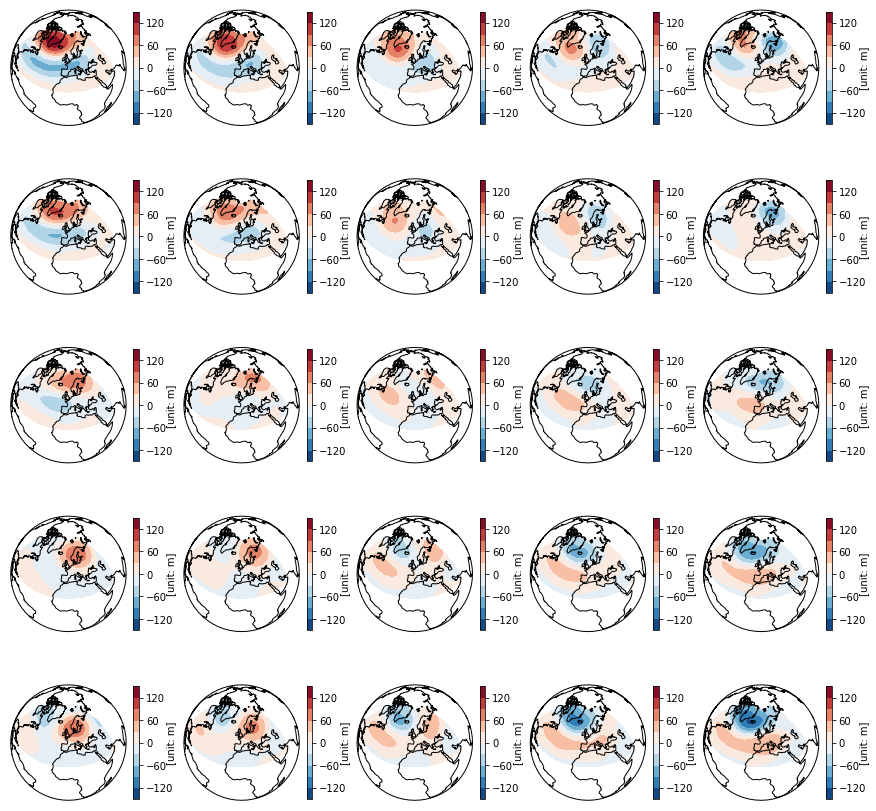

In [6]:
x,y = np.meshgrid(da.X, da.Y)
proj = ccrs.Orthographic(0,45)
fig, axes = plt.subplots(5,5, figsize=(15,15), subplot_kw=dict(projection=proj))

for i in range(sm.codebook.nnodes):
    onecen = codebook[i,:].reshape(ny,nx, order='F')
    cs = axes.flat[i].contourf(x, y, onecen,
                               levels=np.arange(-150, 151, 30), 
                               transform=ccrs.PlateCarree(),
                               cmap='RdBu_r')
    
    cb=fig.colorbar(cs, ax=axes.flat[i], shrink=0.8, aspect=20) 
    cb.set_label('[unit: m]',labelpad=-7)    
    axes.flat[i].coastlines()
    axes.flat[i].set_global()      

### 4.2 Check amounts of each weather regime using hitsmap

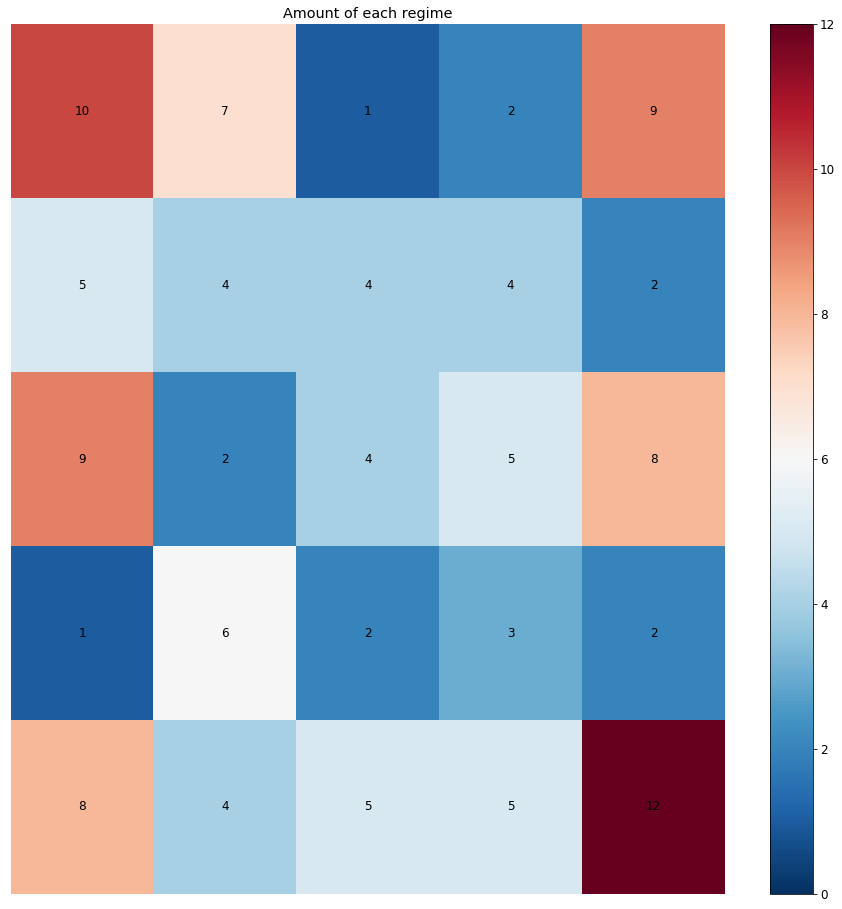

In [16]:
from sompy.visualization.bmuhits import BmuHitsView

vhts  = BmuHitsView(5, 5, "Amount of each regime",text_size=12)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=12, cmap="RdBu_r", logaritmic=False)

### 4.3 K-Means clustering on weather regimes

As we know, there four typical weather regimes over there. So we use 4 clusters.

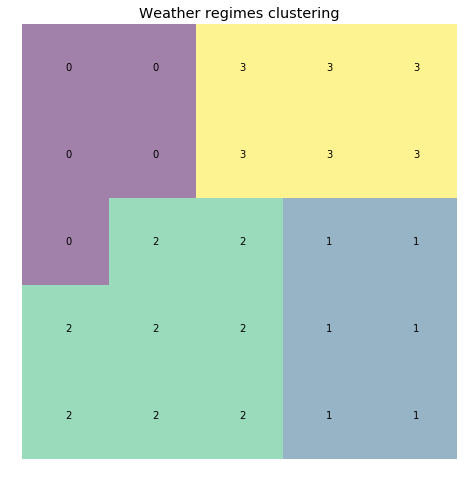

In [8]:
from sompy.visualization.hitmap import HitMapView
sm.cluster(4)
hits = HitMapView(8,8,"Weather regimes clustering",text_size=12)
a = hits.show(sm)

## Summary

Self-Organizing Maps is a powerful tool for the amospheric sciences.

SOMs approach is demonstrated as a way to identify a range of large-scale weather regimes over the North Atlantic. SOMs are used to construct a set of 25 characteristic regimes (nodes) based on monthly reanalysis Z500 for the winter seasons for the period 1979–2010.

SOMs identify the four typical regimes over the north atlantic region are identified validly from the 25 regimes. Moreover, it provides a good way studing the transitions among these typical weather regimes. 

## References

Stéfan van der Walt, S. Chris Colbert and Gaël Varoquaux. The NumPy Array: A Structure for Efficient Numerical Computation, Computing in Science & Engineering, 13, 22-30 (2011), DOI:10.1109/MCSE.2011.37

Fernando Pérez and Brian E. Granger. IPython: A System for Interactive Scientific Computing, Computing in Science & Engineering, 9, 21-29 (2007), DOI:10.1109/MCSE.2007.53

John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007), DOI:10.1109/MCSE.2007.55

Fabian Pedregosa, Gaël Varoquaux, Alexandre Gramfort, Vincent Michel, Bertrand Thirion, Olivier Grisel, Mathieu Blondel, Peter Prettenhofer, Ron Weiss, Vincent Dubourg, Jake Vanderplas, Alexandre Passos, David Cournapeau, Matthieu Brucher, Matthieu Perrot, Édouard Duchesnay. Scikit-learn: Machine Learning in Python, Journal of Machine Learning Research, 12, 2825-2830 (2011) 

Cassou C. (2008). Intraseasonal interaction between the Madden–Julian Oscillation and the North Atlantic Oscillation Nature 455 523–7.

Yiou P. and Nogaj M.(2004). Extreme climatic events and weather regimes over the North Atlantic: when and where? Geophys. Res.
Lett. 31 L07202.

Reusch, D. B., R. B. Alley, and B. C. Hewitson (2007), North Atlantic climate variability from a self-organizing map
perspective, J. Geophys. Res., 112, D02104, doi:10.1029/2006JD007460